In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

tf.compat.v1.disable_eager_execution()

from energyflow.archs.dnn import DNN
from energyflow.datasets import qg_nsubs
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2023-08-28 16:50:30.155292: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-28 16:50:30.195426: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 16:50:30.355560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 16:50:30.356572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 16:50:30.969193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  0
GPUs Available:  []


/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:30: UserWarning: could not import some architectures - cannot import name 'cnn' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))
/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:40: UserWarning: could not import some architectures - cannot import name 'linear' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))


# Parameters and Data

Define the observable $\mathcal{O}^{(n)} = \sum_i z_i (c_1 + c_2 \log^n(\theta_i + c_3))$

In [2]:
# Parameters 
train = 650000
val = 50000
test = 50000
k_order = 1

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs

    l_list = []

    for n in range(8 + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return l_list




# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y2 = to_categorical(Y, num_classes=2)
features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

features = np.array(features)





Data loaded!


# Tensorflow fit

In [6]:










rocs = []
for k_order in [1, 2, 3, 4]:


    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:k_order+1], Y2, val=val, test=test)

    dense_sizes = (100, 100, 100)

    dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')

    # train model
    dnn.fit(X_train, Y_train,
            epochs=50,
            batch_size=500,
            validation_data=(X_val, Y_val),
            verbose=1)

    # get predictions on test data
    preds = dnn.predict(X_test, batch_size=1000)
    dnn.save_weights(f"Data/dnn/linear_O{k_order}.keras")


    # get ROC curve if we have sklearn
    if roc_curve:
        rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

        # get area under the ROC curve
        auc = roc_auc_score(Y_test[:,1], preds[:,1])
        print()
        print('AUC:', auc)
        print()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_10 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_11 (Activation)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_12 (Activation)  (None, 100)               0   

2023-08-28 16:54:49.905967: W tensorflow/c/c_api.cc:300] Operation '{name:'training_8/Adam/dense_2_1/bias/v/Assign' id:2248 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_2_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_2_1/bias/v, training_8/Adam/dense_2_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6291 - auc_6: 0.7119 - val_loss: 0.6147 - val_auc_6: 0.7278
Epoch 2/50
   500/650000 [..............................] - ETA: 16s - loss: 0.5877 - auc_6: 0.7620

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-28 16:54:52.542440: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_5/mul' id:2086 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/activation_13_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6193 - auc_6: 0.7187 - val_loss: 0.6149 - val_auc_6: 0.7219
Epoch 3/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6175 - auc_6: 0.7208 - val_loss: 0.6137 - val_auc_6: 0.7264
Epoch 4/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6171 - auc_6: 0.7215 - val_loss: 0.6140 - val_auc_6: 0.7247
Epoch 5/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6170 - auc_6: 0.7216 - val_loss: 0.6139 - val_auc_6: 0.7251
Epoch 6/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6172 - auc_6: 0.7214 - val_loss: 0.6142 - val_auc_6: 0.7269
Epoch 7/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6172 - auc_6: 0.7215 - val_loss: 0.6139 - val_auc_6: 0.7272
Epoch 8/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6170 - auc_6: 0.7217 - val_loss: 0.6138 - val_auc_6: 0.7262
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 16:57:03.280594: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_13/Softmax' id:1956 op device:{requested: '', assigned: ''} def:{{{node activation_13/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



AUC: 0.7231806892366643

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               400       
                                                                 
 activation_14 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_15 (Activation)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_16 (Activation)  (Non

2023-08-28 16:57:03.674606: W tensorflow/c/c_api.cc:300] Operation '{name:'training_10/Adam/beta_1/Assign' id:2680 op device:{requested: '', assigned: ''} def:{{{node training_10/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_10/Adam/beta_1, training_10/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6190 - auc_7: 0.7148 - val_loss: 0.6104 - val_auc_7: 0.7177
Epoch 2/50
   500/650000 [..............................] - ETA: 15s - loss: 0.5929 - auc_7: 0.7370

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-28 16:57:06.268892: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_6/mul' id:2611 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/activation_17_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6124 - auc_7: 0.7207 - val_loss: 0.6109 - val_auc_7: 0.7235
Epoch 3/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6107 - auc_7: 0.7226 - val_loss: 0.6090 - val_auc_7: 0.7197
Epoch 4/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6102 - auc_7: 0.7231 - val_loss: 0.6084 - val_auc_7: 0.7274
Epoch 5/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6103 - auc_7: 0.7228 - val_loss: 0.6082 - val_auc_7: 0.7228
Epoch 6/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6102 - auc_7: 0.7230 - val_loss: 0.6078 - val_auc_7: 0.7285
Epoch 7/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6101 - auc_7: 0.7231 - val_loss: 0.6078 - val_auc_7: 0.7282
Epoch 8/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6100 - auc_7: 0.7232 - val_loss: 0.6077 - val_auc_7: 0.7248
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 16:59:17.437951: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_17/Softmax' id:2481 op device:{requested: '', assigned: ''} def:{{{node activation_17/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



AUC: 0.7149551972517467

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               500       
                                                                 
 activation_18 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_19 (Activation)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_20 (Activation)  (Non

2023-08-28 16:59:17.871277: W tensorflow/c/c_api.cc:300] Operation '{name:'true_negatives_8/Assign' id:2886 op device:{requested: '', assigned: ''} def:{{{node true_negatives_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_8, true_negatives_8/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6224 - auc_8: 0.7143 - val_loss: 0.6123 - val_auc_8: 0.7117
Epoch 2/50
   500/650000 [..............................] - ETA: 16s - loss: 0.6272 - auc_8: 0.6949

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-28 16:59:20.533292: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_7/mul' id:3124 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/activation_21_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6099 - auc_8: 0.7212 - val_loss: 0.6090 - val_auc_8: 0.7239
Epoch 3/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6087 - auc_8: 0.7224 - val_loss: 0.6084 - val_auc_8: 0.7219
Epoch 4/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6084 - auc_8: 0.7228 - val_loss: 0.6091 - val_auc_8: 0.7227
Epoch 5/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6082 - auc_8: 0.7229 - val_loss: 0.6106 - val_auc_8: 0.7247
Epoch 6/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6081 - auc_8: 0.7230 - val_loss: 0.6083 - val_auc_8: 0.7230
Epoch 7/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6081 - auc_8: 0.7230 - val_loss: 0.6083 - val_auc_8: 0.7227
Epoch 8/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6079 - auc_8: 0.7233 - val_loss: 0.6102 - val_auc_8: 0.7181
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 17:01:31.933024: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_21/Softmax' id:2994 op device:{requested: '', assigned: ''} def:{{{node activation_21/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



AUC: 0.7156655754722654

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               600       
                                                                 
 activation_22 (Activation)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_23 (Activation)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_24 (Activation)  (Non

2023-08-28 17:01:32.379261: W tensorflow/c/c_api.cc:300] Operation '{name:'training_14/Adam/dense_2_4/kernel/m/Assign' id:3750 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/dense_2_4/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/dense_2_4/kernel/m, training_14/Adam/dense_2_4/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6304 - auc_9: 0.7101 - val_loss: 0.6216 - val_auc_9: 0.7212
Epoch 2/50
   500/650000 [..............................] - ETA: 15s - loss: 0.6483 - auc_9: 0.6928

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-28 17:01:35.077959: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_8/mul' id:3637 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8/activation_25_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 4us/sample - loss: 0.6137 - auc_9: 0.7191 - val_loss: 0.6158 - val_auc_9: 0.7187
Epoch 3/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6099 - auc_9: 0.7220 - val_loss: 0.6097 - val_auc_9: 0.7201
Epoch 4/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6084 - auc_9: 0.7232 - val_loss: 0.6093 - val_auc_9: 0.7205
Epoch 5/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6080 - auc_9: 0.7235 - val_loss: 0.6097 - val_auc_9: 0.7203
Epoch 6/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6078 - auc_9: 0.7238 - val_loss: 0.6091 - val_auc_9: 0.7219
Epoch 7/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6078 - auc_9: 0.7238 - val_loss: 0.6100 - val_auc_9: 0.7193
Epoch 8/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.6077 - auc_9: 0.7239 - val_loss: 0.6096 - val_auc_9: 0.7203
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 17:03:49.686723: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_25/Softmax' id:3507 op device:{requested: '', assigned: ''} def:{{{node activation_25/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



AUC: 0.7150960286038411



In [5]:
from energyflow.archs.moment import EFN_moment, PFN_moment

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['font.size'] = '20'

rocs = []
colors = ['red', 'yellow', 'green', 'blue', 'purple', 'pink', "grey", "black"]

for i, k_order in enumerate([1, 2, 3, 4]):


    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:k_order+1], Y2, val=val, test=test)

    dense_sizes = (100, 100, 100)

    dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')
    dnn.load_weights(f"Data/dnn/linear_O{k_order}.keras")


    # get predictions on test data
    preds = dnn.predict(X_test, batch_size=1000)


    # get ROC curve if we have sklearn
    rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()

    if False:
        l = "EFN"
    else:
        l = f"$k = {k_order}$, AUC = {auc : .3f}"
    plt.plot(rocs[i][1], 1-rocs[i][0], '-', color = colors[i], alpha = 0.5, label = l, lw = 3, ls = "--")


# ##### Original #####

X, Y = qg_jets.load(train+val+test)
X = X[:,:,:3].astype(np.float32)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

(z_train, z_val, z_test,
p_train, p_val, p_test,
Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]

dictionary = {'Phi_mapping_dim' : [2,1],
                                        'output_dim' : 1, 'output_act' : 'sigmoid',
                                        'Phi_sizes' : [100, 100], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" : 1e-6,
                                        'F_sizes' : [100,100,100], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                                        'order' : 4 , 'architecture_type':'moment',
                                        'loss': 'binary_crossentropy',}
# moment_efn = EFN_moment(**dictionary, summary=False)



# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))


# # moment_efn.load_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras", by_name=True)
# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))

# # # initialize
# # moment_efn.fit(X_train, Y_train, epochs = 50)
# # moment_efn.save_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras")

# preds = moment_efn.predict(X_test, batch_size=1000)

# print(preds.shape, Y_test.shape)

# get ROC curve if we have sklearn
rocs.append(np.load("roc.npy"))
# np.save("roc", roc_curve(Y_test, preds))

# get area under the ROC curve
auc = 0.831 #roc_auc_score(Y_test, preds)
print()
print('AUC:', auc)
print()


plt.plot(rocs[-1][1], (1-rocs[-1][0]) , '-', color = "blue", alpha = 0.95, label = f"Moment EFN, AUC = {auc: .3f}", lw = 3)





# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)


plt.savefig("Plots/analytic_auc.pdf")
plt.show()




Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0   

ValueError: Layer count mismatch when loading weights from file. Model expected 4 layers, found 2 saved layers.

In [ ]:



# Parameters 
val = 5000
test = 5000
k_order = 4

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


Ls = []
j = max_L
while j >= 1:
    Ls.append(j)
    j = j / 2

num_samples = len(Ls)


# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = 1
    b = 0.5
    c = 0.01

    zs = x[:,0]
    
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    ls = np.power(rs, 0.25)
    
    l0 = 1.0
    l1 = np.sum(zs * ls**1)
    l2 = np.sum(zs * ls**2)
    l3 = np.sum(zs * ls**3)
    l4 = np.sum(zs * ls**4)

    return (l0, l1, l2, l3, l4)



X, Y = qg_jets.load(train+val+test)
Y = to_categorical(Y, num_classes=2)
print("Data loaded!")


features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

features = np.array(features)
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(np.array(features), Y, val=val, test=test)




Data loaded!


In [ ]:

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=4+1, dense_sizes=dense_sizes)

# train model
dnn.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)

angularity_rocs = []
# get ROC curve if we have sklearn
if roc_curve:
    angularity_rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               600       
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_9 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_10 (Activation)  (None, 100)               0   

2023-08-28 15:43:19.423435: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/output_8/kernel/v/Assign' id:2578 op device:{requested: '', assigned: ''} def:{{{node training/Adam/output_8/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/output_8/kernel/v, training/Adam/output_8/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-28 15:43:19.537106: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_8/mul' id:2406 op d

2/2 [==============================] - 0s 7ms/sample - loss: 0.6974 - acc: 0.5000 - val_loss: 0.6853 - val_acc: 0.4852
Epoch 4/50
2/2 [==============================] - 0s 8ms/sample - loss: 0.6805 - acc: 0.5000 - val_loss: 0.6696 - val_acc: 0.6856
Epoch 5/50
2/2 [==============================] - 0s 8ms/sample - loss: 0.6714 - acc: 1.0000 - val_loss: 0.6632 - val_acc: 0.6318
Epoch 6/50
2/2 [==============================] - 0s 7ms/sample - loss: 0.6704 - acc: 0.5000 - val_loss: 0.6577 - val_acc: 0.6400
Epoch 7/50
2/2 [==============================] - 0s 6ms/sample - loss: 0.6649 - acc: 0.5000 - val_loss: 0.6529 - val_acc: 0.6744
Epoch 8/50
2/2 [==============================] - 0s 6ms/sample - loss: 0.6538 - acc: 0.5000 - val_loss: 0.6540 - val_acc: 0.6870
Epoch 9/50
2/2 [==============================] - 0s 6ms/sample - loss: 0.6439 - acc: 1.0000 - val_loss: 0.6605 - val_acc: 0.6310
Epoch 10/50
2/2 [==============================] - 0s 7ms/sample - loss: 0.6385 - acc: 0.5000 - val_l

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 15:43:20.620860: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_11/Softmax' id:2330 op device:{requested: '', assigned: ''} def:{{{node activation_11/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


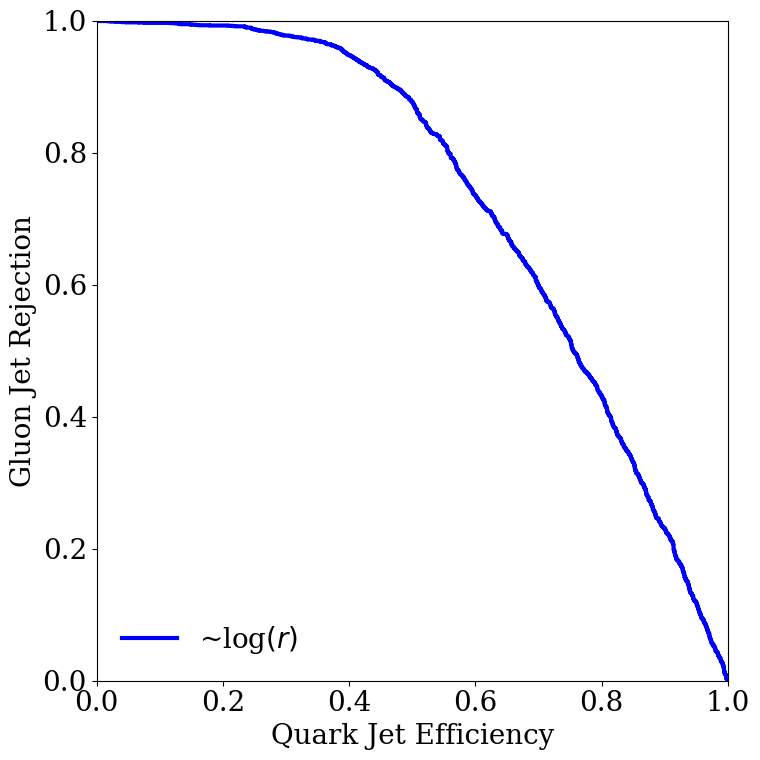

In [ ]:
# some nicer plot settings 
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.autolayout'] = True

# iterate over the ROC curves and plot them
labels = ["~log$(r)$", "Angularities"]
colors = ["blue", "black"]
for i in range(len(angularity_rocs)):
    plt.plot(angularity_rocs[i][1], 1-angularity_rocs[i][0], '-', label = labels[i], lw = 3, color = colors[i])

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()